In [2]:
from os import path
import numpy as np
import cv2
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

In [2]:
!unzip 'drive/Shared drives/539Final/images.zip'

Streaming output truncated to the last 5000 lines.
 extracting: images/Lloyd_Novick_0001.jpg  
 extracting: images/Lloyd_Richards_0001.jpg  
 extracting: images/Lloyd_Ward_0001.jpg  
 extracting: images/Lloyd_Ward_0002.jpg  
  inflating: images/Lois_Smart_0001.jpg  
 extracting: images/Lokendra_Bahadur_Chand_0001.jpg  
 extracting: images/Lonnie_Donegan_0001.jpg  
 extracting: images/Lon_Kruger_0001.jpg  
 extracting: images/Lon_Kruger_0002.jpg  
 extracting: images/Lope_Mendoza_0001.jpg  
 extracting: images/Lord_Hutton_0001.jpg  
 extracting: images/Lord_Hutton_0002.jpg  
 extracting: images/Loretta_Lynn_Harper_0001.jpg  
 extracting: images/Lori_Berenson_0001.jpg  
 extracting: images/Lorne_Michaels_0001.jpg  
 extracting: images/Lorraine_Bracco_0001.jpg  
 extracting: images/Lorraine_Fenton_0001.jpg  
 extracting: images/Louisa_Baileche_0001.jpg  
 extracting: images/Louis_Van_Gaal_0001.jpg  
 extracting: images/Lou_Lang_0001.jpg  
 extracting: images/Lou_Piniella_0001.jpg  
 extra

In [3]:
path = 'drive/Shared drives/539Final/'
# read iris.csv
legend = pd.read_csv(path + 'legend.csv').to_numpy()

# split into label and identifiers
tmp_labels = legend[:, 2]
tmp_pic_names = legend[:, 1]
tmp_labels = np.array([i.lower() for i in tmp_labels])
print(tmp_pic_names.shape)
print(tmp_pic_names.shape)


(13690,)
(13690,)


In [4]:
#Data Preprocessing
folder = 'images/'
imgs = []
for name in tmp_pic_names[:]:
    
    #read the img
    img = cv2.imread(folder+name)
    #resize
    final_img = cv2.resize(img, (128,128))
    
    imgs.append(final_img)

In [5]:
# autoencode labels for training
onehot_encoder = OneHotEncoder(sparse=False)
labels = onehot_encoder.fit_transform(tmp_labels.reshape(-1, 1))

# feature list for reverse transform
print(onehot_encoder.get_feature_names())

['x0_anger' 'x0_contempt' 'x0_disgust' 'x0_fear' 'x0_happiness'
 'x0_neutral' 'x0_sadness' 'x0_surprise']


In [6]:
input = np.array(imgs)
label = np.array(labels)

In [ ]:
# save processed data for later use
np.save('input_incep_v3', imgs)
np.save('labels_incep_v3', labels)

In [ ]:
input = np.load('input_incep_v3.npy')
label = np.load('labels_incep_v3.npy')

In [7]:
#import model from keras
from keras.models import Model
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, BatchNormalization
from keras.applications.inception_v3 import InceptionV3
#from keras.applications.inception_v3 import preprocess_input
from keras.applications.resnet import preprocess_input
from keras import Sequential

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))
#InceptionV3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128,128,3))


In [8]:
CLASSES = label.shape[1]
print('Classes:', CLASSES)

model = Sequential()
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(CLASSES, activation='softmax'))

for layer in resnet_model.layers:
    #if isinstance(layer, BatchNormalization):
        #layer.trainable = True
    #else:
    layer.trainable = False

Classes: 8


In [9]:
from sklearn.model_selection import train_test_split
#split out the test data
X_train, X_test, y_train, y_test = train_test_split(input, label, test_size=0.33, random_state=0)


X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(9172, 128, 128, 3)
(9172, 8)
(4518, 128, 128, 3)
(4518, 8)


In [10]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
start_time = time.time()
EPOCHS = 100
STEPS_PER_EPOCH = 2
MODEL_FILE = 'final_test1.model'

history = model.fit(
    x = X_train, y = y_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_split= 0.2,
    shuffle = True)
  
model.save(MODEL_FILE)
print(f"Time consumed for {EPOCHS} epochs: {(time.time() - start_time )/60 // 0.01 * 0.01} mins")

Epoch 1/100
2/2 [==============================] - 12s 6s/step - loss: 2.3513 - accuracy: 0.3595 - val_loss: 3.2785 - val_accuracy: 0.5101
Epoch 2/100
2/2 [==============================] - 6s 3s/step - loss: 1.6575 - accuracy: 0.5490 - val_loss: 2.2489 - val_accuracy: 0.5766
Epoch 3/100
2/2 [==============================] - 6s 3s/step - loss: 1.3176 - accuracy: 0.6575 - val_loss: 2.0232 - val_accuracy: 0.5842
Epoch 4/100
2/2 [==============================] - 6s 3s/step - loss: 1.1876 - accuracy: 0.6918 - val_loss: 1.7337 - val_accuracy: 0.6278
Epoch 5/100
2/2 [==============================] - 6s 3s/step - loss: 1.1147 - accuracy: 0.7195 - val_loss: 1.7998 - val_accuracy: 0.6131
Epoch 6/100
2/2 [==============================] - 6s 3s/step - loss: 1.0101 - accuracy: 0.7450 - val_loss: 1.6695 - val_accuracy: 0.6272
Epoch 7/100
2/2 [==============================] - 6s 3s/step - loss: 0.9452 - accuracy: 0.7596 - val_loss: 1.4812 - val_accuracy: 0.6469
Epoch 8/100
2/2 [================

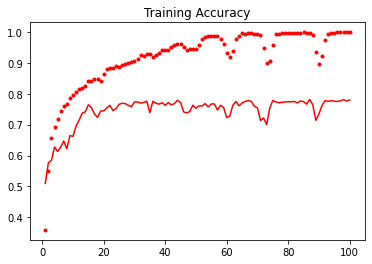

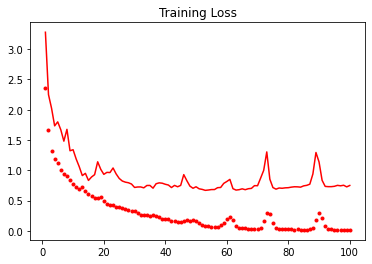

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.plot(epochs, val_acc,'r')
plt.plot(epochs, acc,'r.')
plt.title("Training Accuracy")

plt.figure()
plt.plot(epochs, val_loss,'r')
plt.plot(epochs,loss,'r.')
plt.title("Training Loss")
plt.show()

In [14]:
 #test result
 test = model.evaluate(x = X_test, y = y_test)

142/142 [==============================] - 5s 37ms/step - loss: 0.7645 - accuracy: 0.7711
